In [15]:
# ============================================
# LIBRARIES & DIRECTORIES, LOADS DATA
# =============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, precision_score, recall_score, auc
from sklearn.ensemble import RandomForestClassifier

DATA_PATH = os.path.join("..", "data", "processed", "flux_with_features.csv")
df = pd.read_csv(DATA_PATH)
df["time"] = pd.to_datetime(df["time"])

In [16]:
# ============================================
# DEFINES FEATURE COLUMNS & TARGETS
# =============================================

manual_features = [
    "xrsb_flux_log",
    "flux_diff_5min",
    "flux_rate",
    "flux_acceleration",
    "flux_max_diff_5min",
    "rolling_avg_5min", "rolling_min_5min", "rolling_max_5min", "rolling_std_5min",
    "rolling_avg_15min", "rolling_min_15min", "rolling_max_15min", "rolling_std_15min",
    "rolling_avg_30min", "rolling_min_30min", "rolling_max_30min", "rolling_std_30min",
    "rolling_avg_60min", "rolling_min_60min", "rolling_max_60min", "rolling_std_60min",
    "flux_above_background",
    "flux_rising",
    "rising_streak"
]
feature_cols = [col for col in df.columns if "lag_" in col] + manual_features

# These are the time-target columns, or 'horizons'
targets = {
    "6h": "flare_in_next_6h",
    "12h": "flare_in_next_12h",
    "18h": "flare_in_next_18h",
    "24h": "flare_in_next_24h",
    "48h": "flare_in_next_48h",
    "72h": "flare_in_next_72h"
}


== Training for next 6h flare prediction ==
scale_pos_weight: 1.14
Fitting...
Predicting...
Best threshold for F1: 0.48
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.93      0.79      0.85    458658
           1       0.79      0.93      0.86    403902

    accuracy                           0.85    862560
   macro avg       0.86      0.86      0.85    862560
weighted avg       0.87      0.85      0.85    862560

=== Confusion Matrix ===
[[361525  97133]
 [ 28367 375535]]
Accuracy: 0.855
F1 Score: 0.857
ROC AUC: 0.923


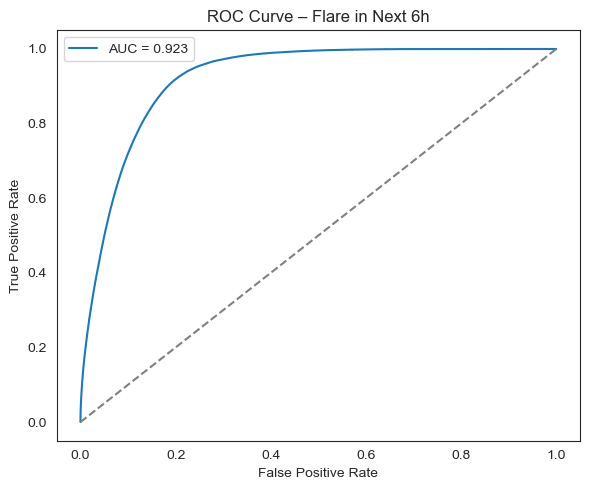

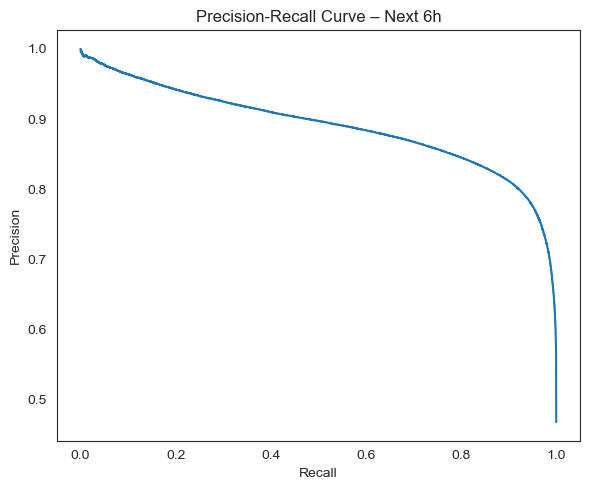

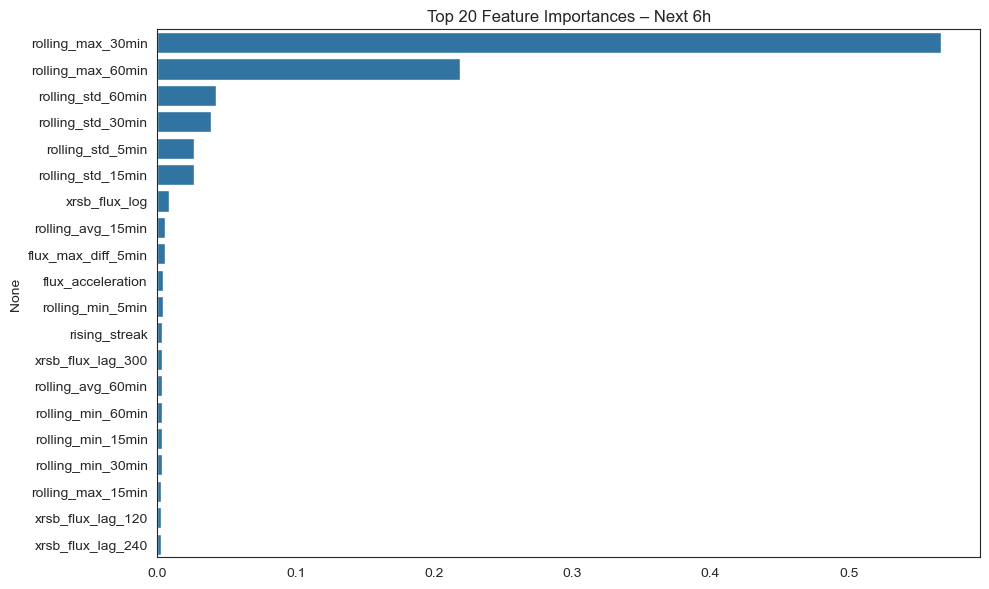


== Training for next 12h flare prediction ==
scale_pos_weight: 0.84
Fitting...
Predicting...
Best threshold for F1: 0.39
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.91      0.83      0.87    394119
           1       0.87      0.93      0.90    468441

    accuracy                           0.88    862560
   macro avg       0.89      0.88      0.88    862560
weighted avg       0.89      0.88      0.88    862560

=== Confusion Matrix ===
[[326748  67371]
 [ 32109 436332]]
Accuracy: 0.885
F1 Score: 0.898
ROC AUC: 0.943


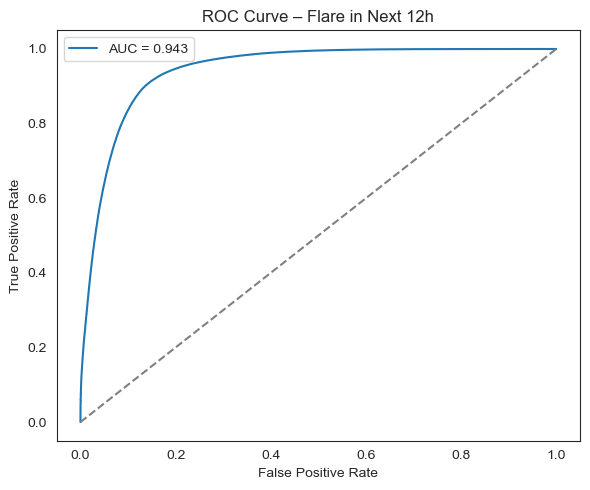

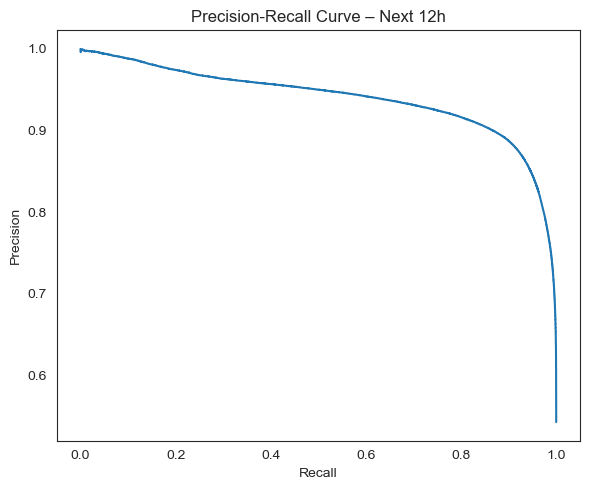

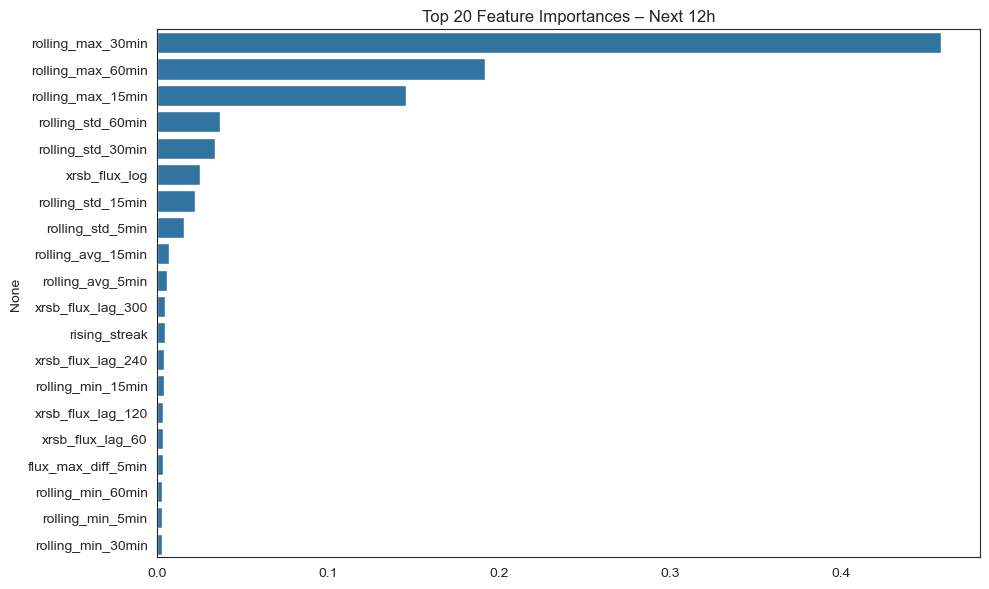


== Training for next 18h flare prediction ==
scale_pos_weight: 0.71
Fitting...
Predicting...
Best threshold for F1: 0.35
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.84      0.87    359250
           1       0.89      0.93      0.91    503310

    accuracy                           0.90    862560
   macro avg       0.90      0.89      0.89    862560
weighted avg       0.90      0.90      0.90    862560

=== Confusion Matrix ===
[[303422  55828]
 [ 33700 469610]]
Accuracy: 0.896
F1 Score: 0.913
ROC AUC: 0.951


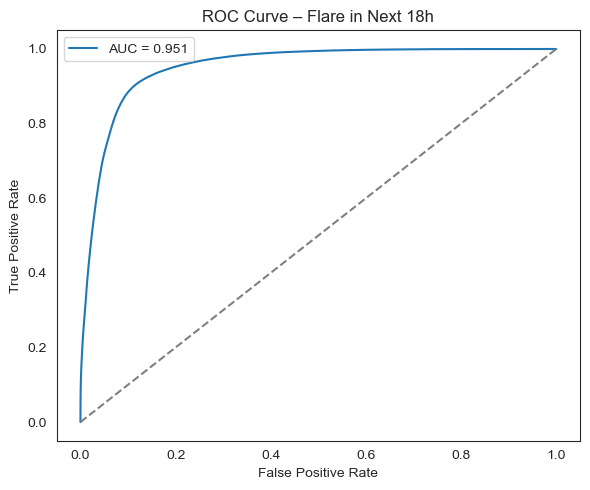

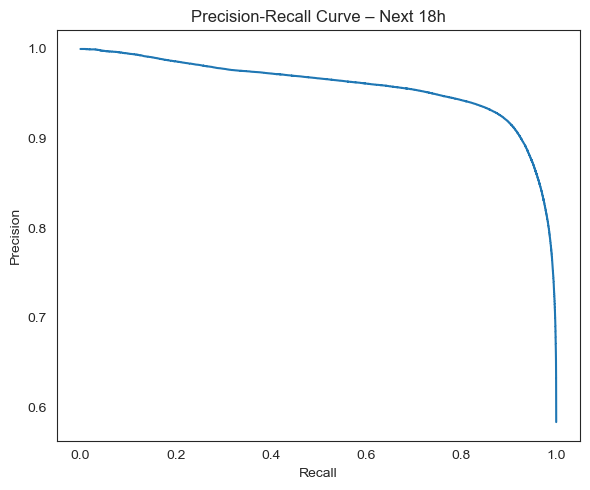

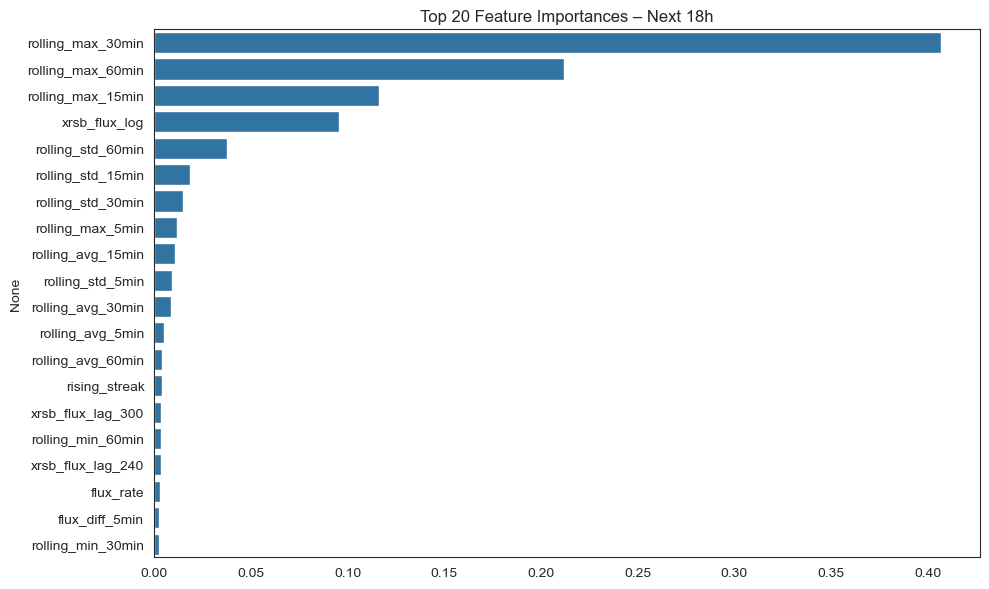


== Training for next 24h flare prediction ==
scale_pos_weight: 0.63
Fitting...
Predicting...
Best threshold for F1: 0.34
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.89      0.86      0.87    333372
           1       0.91      0.93      0.92    529188

    accuracy                           0.90    862560
   macro avg       0.90      0.90      0.90    862560
weighted avg       0.90      0.90      0.90    862560

=== Confusion Matrix ===
[[286880  46492]
 [ 35556 493632]]
Accuracy: 0.905
F1 Score: 0.923
ROC AUC: 0.960


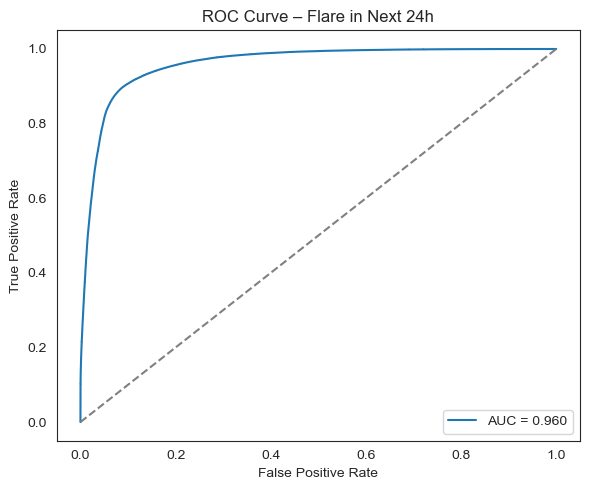

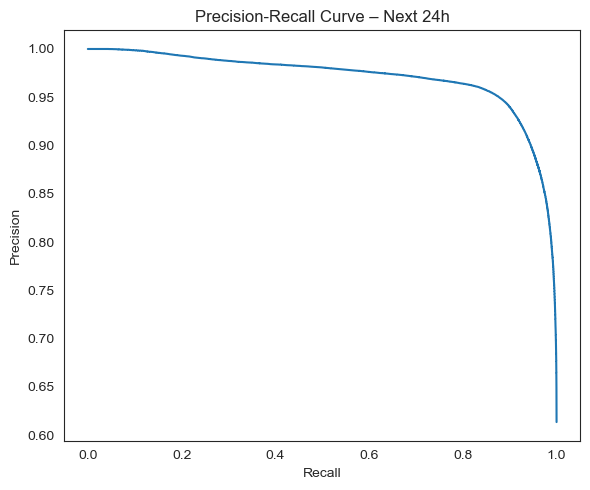

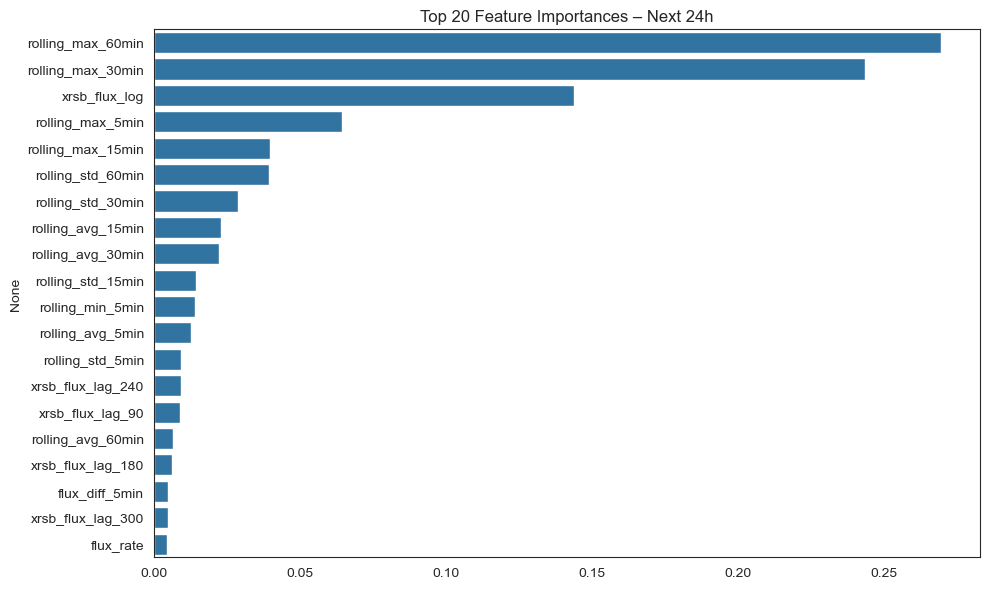


== Training for next 48h flare prediction ==
scale_pos_weight: 0.48
Fitting...
Predicting...
Best threshold for F1: 0.29
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.88      0.85      0.87    279468
           1       0.93      0.95      0.94    583092

    accuracy                           0.92    862560
   macro avg       0.91      0.90      0.90    862560
weighted avg       0.92      0.92      0.92    862560

=== Confusion Matrix ===
[[238272  41196]
 [ 31600 551492]]
Accuracy: 0.916
F1 Score: 0.938
ROC AUC: 0.973


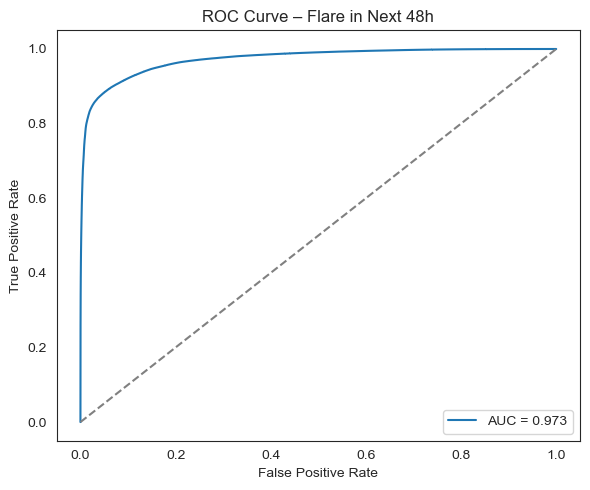

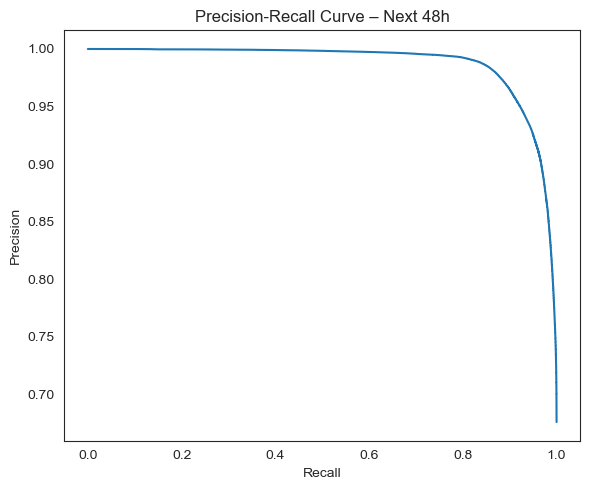

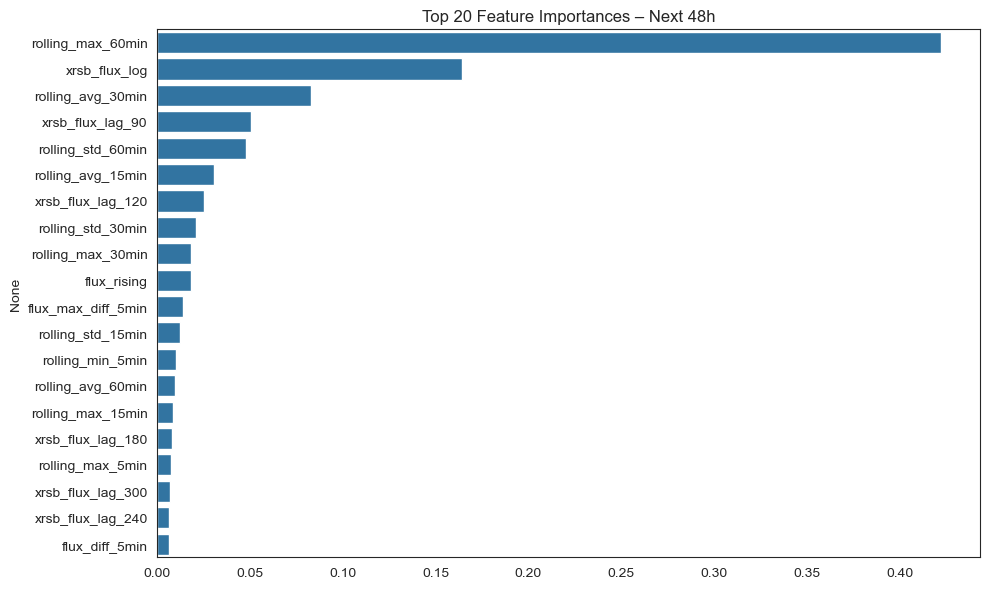


== Training for next 72h flare prediction ==
scale_pos_weight: 0.42
Fitting...
Predicting...
Best threshold for F1: 0.28
=== Classification Report ===
              precision    recall  f1-score   support

           0       0.85      0.86      0.86    253616
           1       0.94      0.94      0.94    608944

    accuracy                           0.91    862560
   macro avg       0.90      0.90      0.90    862560
weighted avg       0.92      0.91      0.92    862560

=== Confusion Matrix ===
[[218861  34755]
 [ 38658 570286]]
Accuracy: 0.915
F1 Score: 0.940
ROC AUC: 0.971


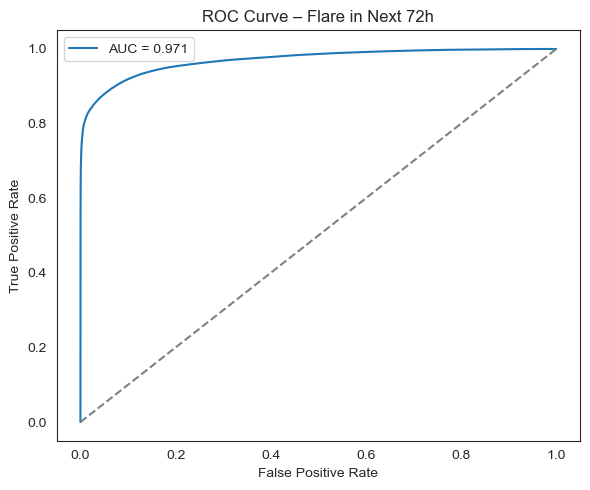

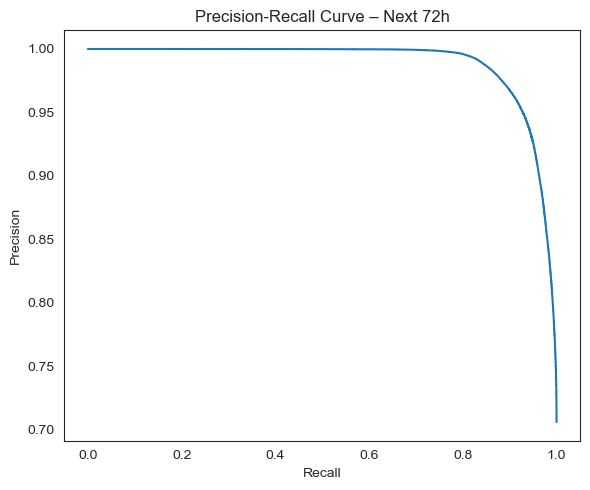

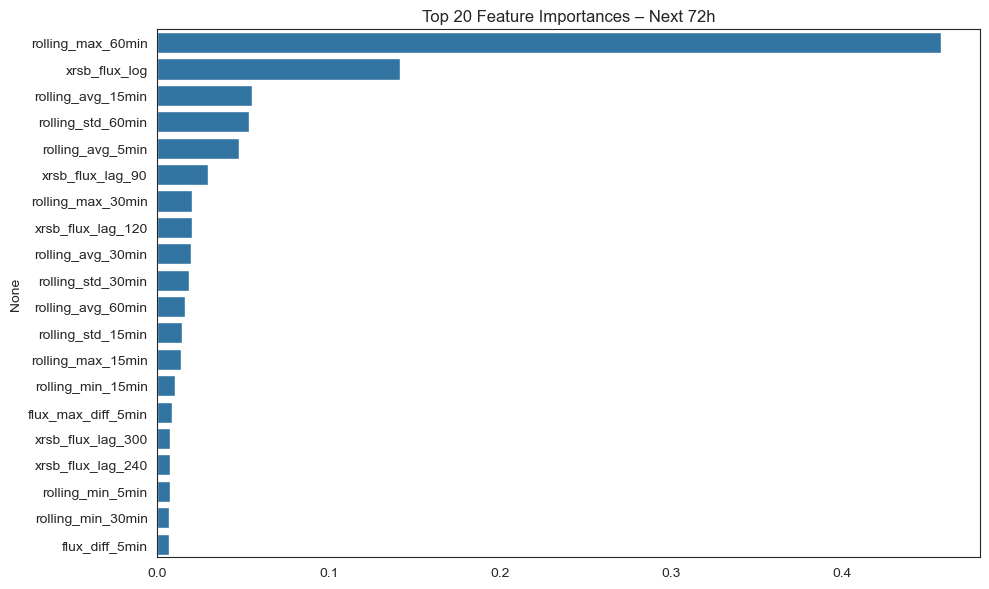

In [14]:
# ============================================
# RUNS MODEL FOR EACH TIME HORIZON & EVALUATES
# =============================================

# run with forest/other applicable models

for label, target_col in targets.items():
    print(f"\n================================================")
    print(f"== Training for next {label} flare prediction ==")
    print(f"================================================")

    # Sets features and targets
    X = df[feature_cols]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=3, stratify=y
    )

    # Sets scale_pos_weight as a ratio of non-flares to flares
    # XGBoost has this as a parameter to help compensate for imbalanced classes
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    print(f"scale_pos_weight: {scale_pos_weight:.2f}")

    # Trains model
    # can play with these too
    clf = xgb.XGBClassifier(
        n_estimators=200, # number of trees to build
        learning_rate=0.05, # contribution of each tree
        max_depth=6, # max depth of each tree
        scale_pos_weight=scale_pos_weight, 
        eval_metric="logloss", # logarithmic loss b/c of large values
        n_jobs=-1, # enables parallel training to use all available CPU cores
        verbosity=0, # no info printed while training
        random_state=3
    )

    print("Fitting...")
    clf.fit(X_train, y_train)

    print("Predicting...")
    y_proba = clf.predict_proba(X_test)[:, 1]

    # Finds the best threshold for F1-score
    thresholds = np.linspace(0, 1, 101)
    f1_scores = [f1_score(y_test, y_proba > t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold for F1: {best_threshold:.2f}")

    # Creates adjusted predictions (y_pred_adj) with the new threshold
    y_pred_adj = (y_proba > best_threshold).astype(int)

    # Evaluation
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred_adj))

    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred_adj))

    print(f"Accuracy: {accuracy_score(y_test, y_pred_adj):.3f}")
    print(f"F1 Score: {f1_score(y_test, y_pred_adj):.3f}")
    print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.3f}")

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    sns.set_style('white')
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
    plt.plot([0, 1], [0, 1], "--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve – Flare in Next {label}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision-Recall score
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    sns.set_style('white')
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve – Next {label}")
    plt.tight_layout()
    plt.show()

    # Feature importance
    importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    plt.figure(figsize=(10, 6))
    sns.set_style('white')
    sns.barplot(x=importances.values[:20], y=importances.index[:20]) # only top 20
    plt.title(f"Top 20 Feature Importances – Next {label}")
    plt.tight_layout()
    plt.show()


== Training for next 6h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
85.63%
======PRECISION SCORE======
80.17%
======RECALL SCORE======
0.9209362667181643
======F1 SCORE======
0.857217261047416
======CONFUSION MATRIX======
[[366678  91980]
 [ 31934 371968]]


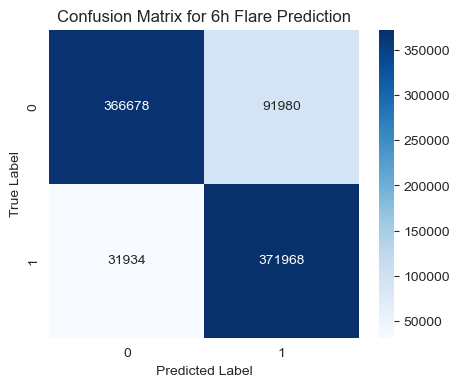

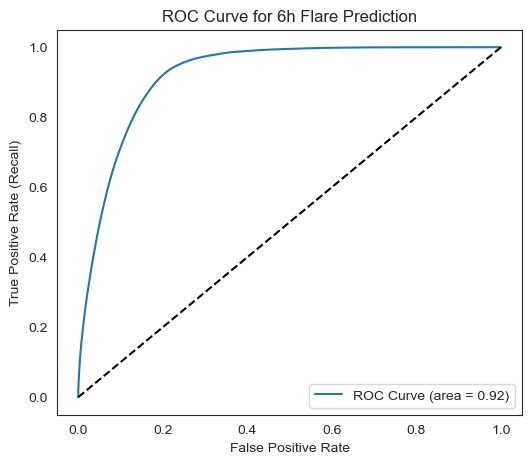

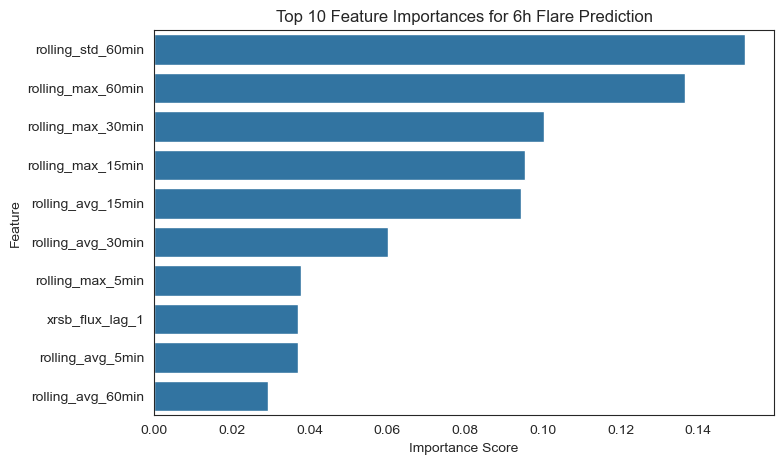


== Training for next 12h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
88.65%
======PRECISION SCORE======
87.72%
======RECALL SCORE======
0.9197913931530332
======F1 SCORE======
0.8980074176044618
======CONFUSION MATRIX======
[[333819  60300]
 [ 37573 430868]]


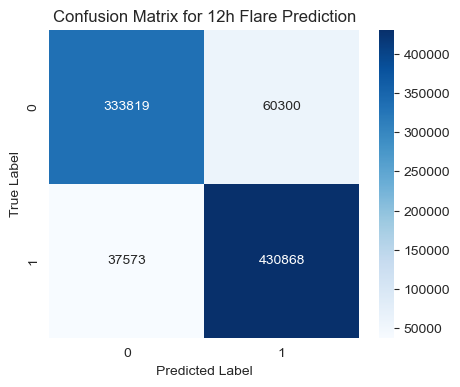

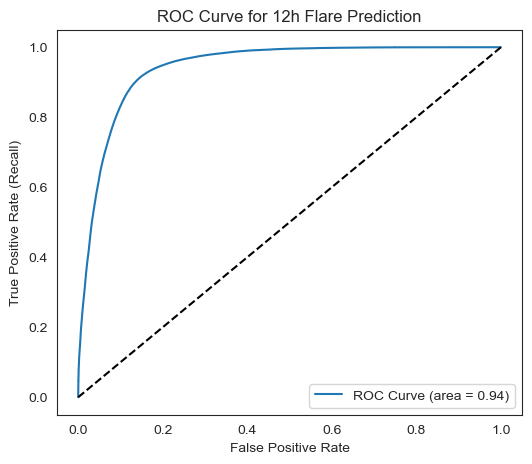

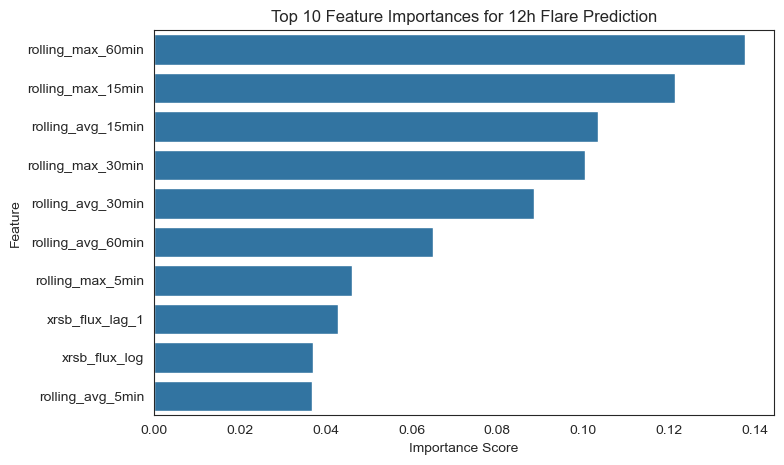


== Training for next 18h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
89.86%
======PRECISION SCORE======
90.73%
======RECALL SCORE======
0.9202737875265741
======F1 SCORE======
0.9137489544371321
======CONFUSION MATRIX======
[[311935  47315]
 [ 40127 463183]]


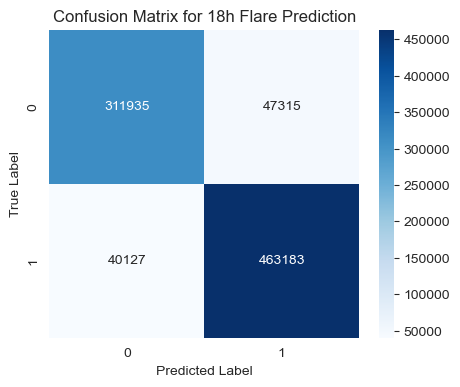

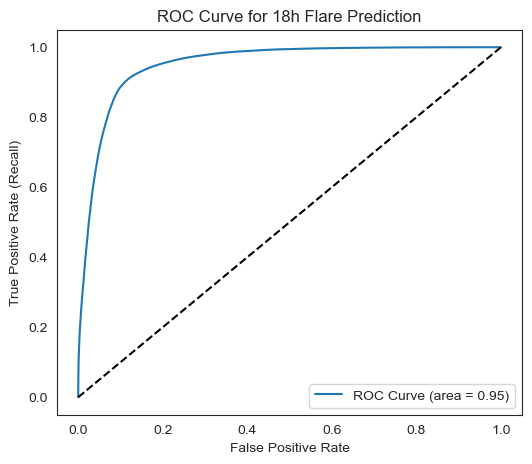

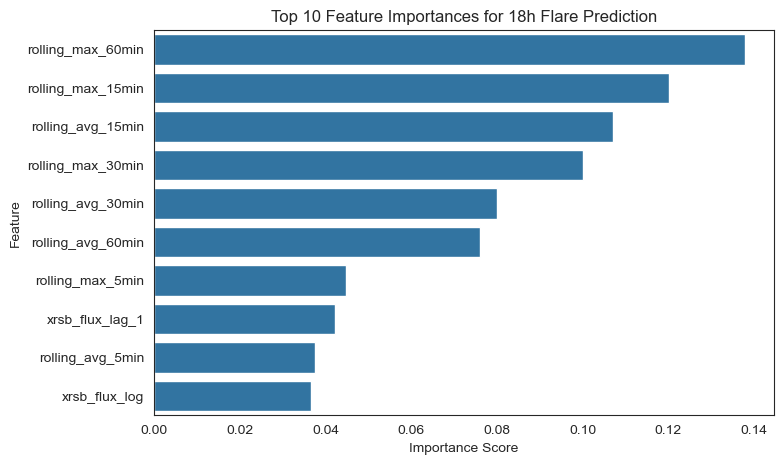


== Training for next 24h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
90.65%
======PRECISION SCORE======
92.48%
======RECALL SCORE======
0.9225908372827805
======F1 SCORE======
0.9236756396782618
======CONFUSION MATRIX======
[[293651  39721]
 [ 40964 488224]]


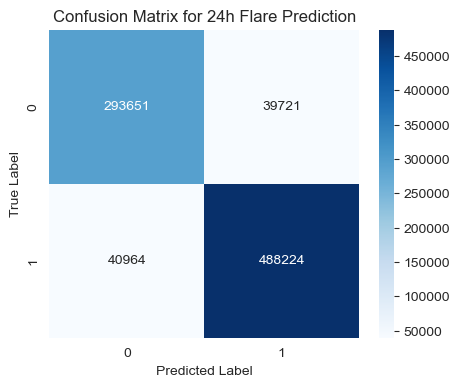

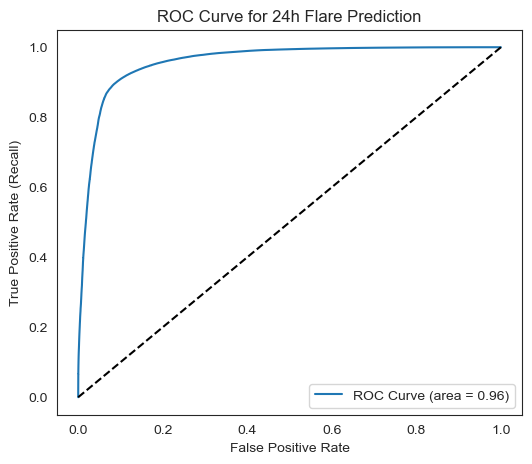

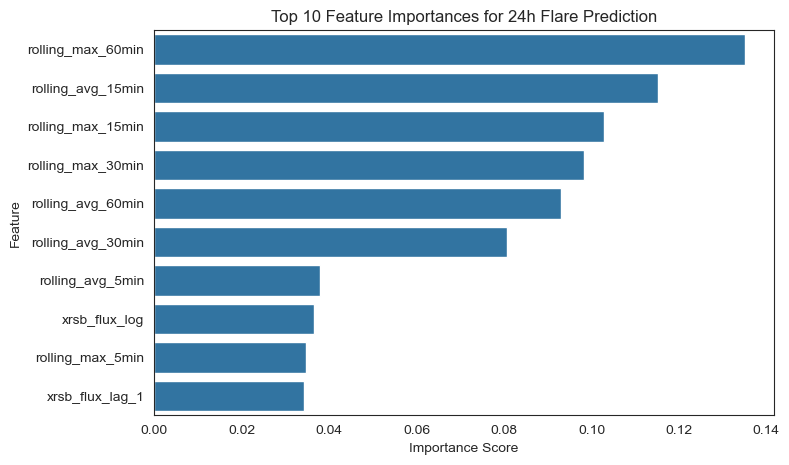


== Training for next 48h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
91.74%
======PRECISION SCORE======
93.72%
======RECALL SCORE======
0.940806939556708
======F1 SCORE======
0.9389888415513992
======CONFUSION MATRIX======
[[242695  36773]
 [ 34515 548577]]


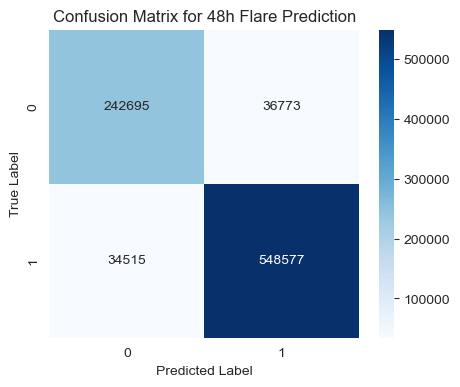

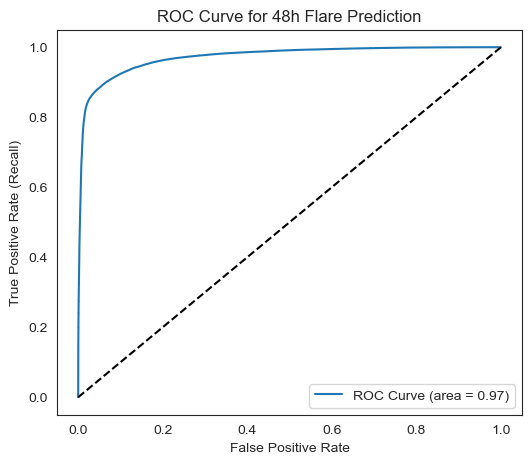

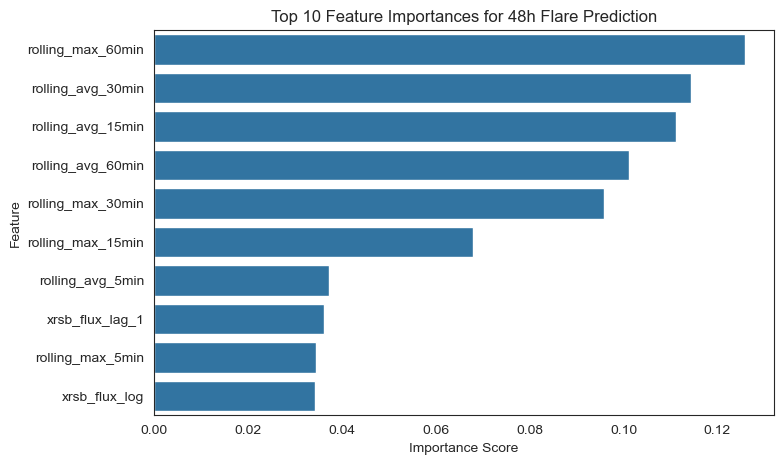


== Training for next 72h flare prediction ==
Fitting...
Predicting...
======ACCURACY SCORE======
91.61%
======PRECISION SCORE======
94.65%
======RECALL SCORE======
0.9339364539267979
======F1 SCORE======
0.940156881545341
======CONFUSION MATRIX======
[[221445  32171]
 [ 40229 568715]]


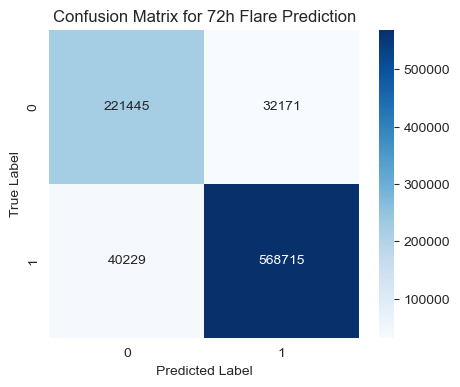

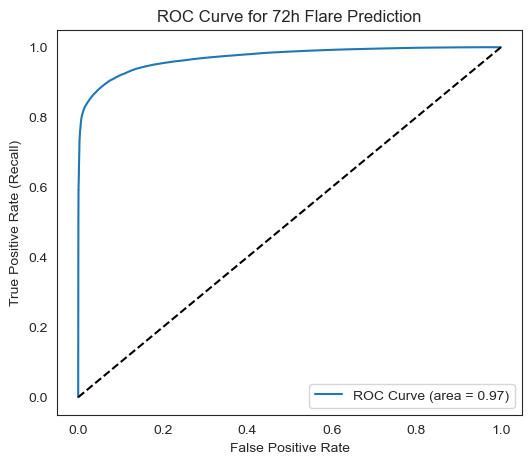

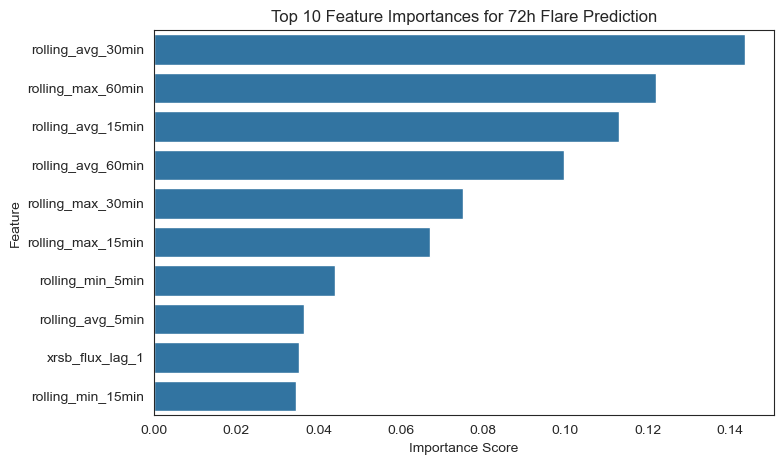

In [18]:
# ========================================================================
# RUNS MODEL FOR EACH TIME HORIZON & EVALUATES AS RANDOM FOREST CLASSIFIER
# ========================================================================

for label, target_col in targets.items():
    print(f"\n================================================")
    print(f"== Training for next {label} flare prediction ==")
    print(f"================================================")

    # Sets features and targets
    X = df[feature_cols]
    y = df[target_col]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=3, stratify=y
    )

    
    model = RandomForestClassifier(
        n_estimators=100,  
        max_depth=10,       
        min_samples_split=5, 
        max_features='sqrt', 
        random_state=3,
        n_jobs=-1           # Use all cores
    )

    # Fit model
    print("Fitting...")
    model.fit(X_train, y_train)

    # Predict
    print("Predicting...")
    y_pred = model.predict(X_test)
    y_probs = model.predict_proba(X_test)[:, 1]  # For ROC/PR curves

    # Metrics
    print("======ACCURACY SCORE======")
    acc = accuracy_score(y_test, y_pred)
    print("{:.2f}%".format(acc * 100))
    print("======PRECISION SCORE======")
    pre = precision_score(y_test, y_pred, zero_division=0)
    print("{:.2f}%".format(pre * 100))
    print("======RECALL SCORE======")
    print(recall_score(y_test, y_pred, zero_division=0))
    print("======F1 SCORE======")
    print(f1_score(y_test, y_pred, zero_division=0))
    print("======CONFUSION MATRIX======")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

     # ====== CONFUSION MATRIX HEATMAP ======
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for {label} Flare Prediction")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # ====== ROC CURVE ======
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f"ROC Curve (area = {roc_auc:.2f})")
    plt.plot([0,1], [0,1], 'k--')  # Diagonal line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.title(f"ROC Curve for {label} Flare Prediction")
    plt.legend()
    plt.show()

    # ====== FEATURE IMPORTANCES ======
    importances = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]  # Sort by importance

    plt.figure(figsize=(8,5))
    sns.barplot(x=importances[indices][:10], y=feature_names[indices][:10])
    plt.title(f"Top 10 Feature Importances for {label} Flare Prediction")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.show()


